## (import)

In [2]:
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.pyplot import imshow
import math
import os
import cv2
%matplotlib inline

# !!!TEST PART !!!

In [148]:
main_dir = '/home/integral-m/Рабочий стол/KTI_test/'
mask1 = '3_onco_predict.png'
#mask1 = np.asarray(Image.open(main_dir+mask1))
#imshow(mask1)

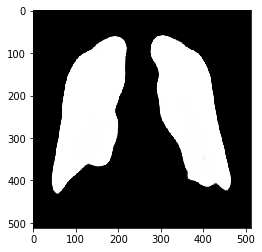

In [149]:
# пример маски

imshow(Image.open(main_dir+mask1))

In [146]:
main_dir = '/home/integral-m/Рабочий стол/KTI_test/'
mask1 = '2_onco_predict.png'

### часть 1 - получение обрезанной маски

In [294]:

def clean_array(img):
    if type(img) == str:
        array = np.asarray(Image.open(img))
    else:
        array = np.asarray(img)
    new_array = []
    array = np.concatenate(array)
    for element in array:
        if element<120:
            new_array+=[0]
        else:
            new_array+=[250]
    return np.asarray(new_array).reshape(np.asarray(Image.open(img)).shape)

In [151]:

def roof_floor(array):
    #array = np.asarray(Image.open(img, 'r'))
    #array = clean_array(array)
    floor = 0
    for element in array:
        if max(element) == 0:
            floor+=1
        else:
            break
    roof = 0
    for element in reversed(array):
        if max(element) == 0:
            roof+=1
        else:
            break
    floor_array = array[floor:int(array.shape[0])- roof]
    return floor_array

In [152]:
floor_array_mask = (roof_floor(clean_array(np.asarray(Image.open(main_dir+mask1)))))

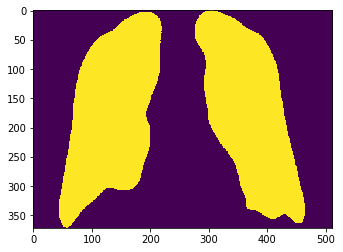

In [153]:
imshow(floor_array_mask)

### часть 2 - треть маски

In [154]:
def half_mask(array):
    #mask_array = np.asarray(Image.open(img, 'r'))
    max_num = []
    for element in array:
        max_num+= [max(element)]
    mask_array = array/(max(max_num))
    half_mask = []
    for i in range(3*len(mask_array)/4, len(mask_array)):
        half_mask+=[mask_array[i]]
    half_mask = np.asarray(half_mask)
    return half_mask

In [155]:
half_mask_array = half_mask(floor_array_mask)

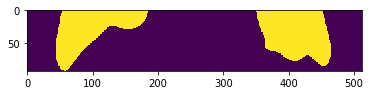

In [156]:
imshow(half_mask_array)

### Часть 3 - расчет сердца из половин

In [159]:
def where_center_is(array):
    i = 0
    for element in array:
        if element == 0:
            i+=1
        else:
            break
    n=0
    for element in array[i:len(array)]:
        if element == 1:
            n+=1
        else:
            break
    j = 0
    for element in reversed(array):
        if element == 0:
            j+=1
        else:
            break
    k = 0
    for element in reversed(array[0:len(array)-j]):
        if element == 1:
                k+=1
        else:
            break
    return (i+n)+(int(len(array))-(j+k)-(i+n))/2
# возвращает int число - центр где нули между едениц

def left_heart(matrix):  
    n = []
    m = 0
    for element in matrix:
        m=0
        #for i in reversed(element[0:len(element)/2]):
        for i in reversed(element[0:int(where_center_is(matrix[0]))]):
            if i == 0:
                m+=1
            else:
                n+=[m]
                m=0
                break
    return n

def right_heart(matrix):
    n = []
    m = 0
    for element in matrix:
        m=0
        for i in element[int(where_center_is(matrix[0])):len(element)]:
            if i == 0:
                m+=1
            else:
                n+=[m]
                m=0
                break
    return n

# возвращают влево и вправо координаты от центра до пересечения с внутренними контурами


def max_in_dict(matrix):
    f = {}
    l = []
    for i in range(1,len(matrix)):
        #print i,abs(a[i-1]-a[i])
        f[matrix[i-1]] = abs(matrix[i-1]-matrix[i])
        l+= [abs(matrix[i-1]-matrix[i])]
    for key,value in f.items():
        if value == max(l):
            return key

In [162]:
right = max_in_dict(right_heart(half_mask_array))
print right

138


In [163]:
left = max_in_dict(left_heart(half_mask_array))
print left

105


In [164]:
heart = left + right
print heart

243


### Часть 4 - расчет ширины груди

In [166]:
def count_zero_board(matrix):
    n= []
    m = 0
    for element in matrix:
        m=0
        for i in element:
            if i == 0:
                m+=1
            else:
                n+=[m]
                m=0
                break
    return min(n)

def count_zero_board_reverse(matrix):
    n= []
    m = 0
    for element in matrix:
        m=0
        for i in reversed(element):
            if i == 0:
                m+=1
            else:
                n+=[m]
                m=0
                break
    return min(n)

In [169]:
left_corner = count_zero_board(half_mask_array)
print left_corner

44


In [171]:
right_corner = count_zero_board_reverse(half_mask_array)
print right_corner

48


In [172]:
chest = len(half_mask_array[0])
print chest

512


### New one def

In [183]:
def cardio_index(image):   
    cut_mask = roof_floor(clean_array(image))
    cut_mask = half_mask(cut_mask)
    left_part = max_in_dict(left_heart(cut_mask))
    right_part = max_in_dict(right_heart(cut_mask))
    left_corner = count_zero_board(cut_mask)
    right_corner = count_zero_board_reverse(cut_mask)
    return str(round(float(left_part+right_part)/\
        (len(cut_mask[0])-left_corner+right_corner),3)*100)+' %'
    



In [184]:
cardio_index(main_dir+mask1)

'47.1 %'

In [239]:
for element in os.listdir(main_dir):
    print cardio_index(main_dir+element)

38.6 %
47.1 %
53.4 %
49.9 %
62.5 %


In [232]:
test = []
for element in os.listdir(main_dir):
    print cardio_index(main_dir+element)
    test+=[cardio_index(main_dir+element)]

38.6 %
47.1 %
53.4 %
49.9 %
62.5 %


In [234]:
dir_montgomery = '/home/integral-m/dataset1/montgomery/label/'
mgm = []
for element in os.listdir(dir_montgomery)[0:5]:
    print cardio_index(dir_montgomery+element)
    mgm+=[cardio_index(dir_montgomery+element)]

37.6 %
25.5 %
22.3 %
28.5 %
23.6 %


In [235]:
china_dir = "/home/integral-m/Рабочий стол/zhenzen_mask/"
chn = []
for element in os.listdir(china_dir)[0:5]:
    print cardio_index(china_dir+element)
    chn += [cardio_index(china_dir+element)]

28.4 %
44.1 %
34.8 %
28.9 %
40.7 %


In [236]:
result = pd.DataFrame({'mntgmery': mgm, 'shenzen': chn, 'predict': test})

In [237]:
result.head()

,mntgmery,predict,shenzen
0,37.6 %,38.6 %,28.4 %
1,25.5 %,47.1 %,44.1 %
2,22.3 %,53.4 %,34.8 %
3,28.5 %,49.9 %,28.9 %
4,23.6 %,62.5 %,40.7 %


In [240]:
#####!!!!! ONE DEF !!!!!

In [ ]:
def clean_array(img):
    array = np.asarray(Image.open(img))
    new_array = []
    array = np.concatenate(array)
    for element in array:
        if element<120:
            new_array+=[0]
        else:
            new_array+=[250]
    return np.asarray(new_array).reshape(np.asarray(Image.open(img)).shape)


def roof_floor(array):
    floor = 0
    for element in array:
        if max(element) == 0:
            floor+=1
        else:
            break
    roof = 0
    for element in reversed(array):
        if max(element) == 0:
            roof+=1
        else:
            break
    floor_array = array[floor:int(array.shape[0])- roof]
    return floor_array


def half_mask(array):
    max_num = []
    for element in array:
        max_num+= [max(element)]
    mask_array = array/(max(max_num))
    half_mask = []
    for i in range(3*len(mask_array)/4, len(mask_array)):
        half_mask+=[mask_array[i]]
    half_mask = np.asarray(half_mask)
    return half_mask


def where_center_is(array):
    i = 0
    for element in array:
        if element == 0:
            i+=1
        else:
            break
    n=0
    for element in array[i:len(array)]:
        if element == 1:
            n+=1
        else:
            break
    j = 0
    for element in reversed(array):
        if element == 0:
            j+=1
        else:
            break
    k = 0
    for element in reversed(array[0:len(array)-j]):
        if element == 1:
                k+=1
        else:
            break
    return (i+n)+(int(len(array))-(j+k)-(i+n))/2



def left_heart(matrix):  
    n = []
    m = 0
    for element in matrix:
        m=0
        for i in reversed(element[0:int(where_center_is(matrix[0]))]):
            if i == 0:
                m+=1
            else:
                n+=[m]
                m=0
                break
    return n


def right_heart(matrix):
    n = []
    m = 0
    for element in matrix:
        m=0
        for i in element[int(where_center_is(matrix[0])):len(element)]:
            if i == 0:
                m+=1
            else:
                n+=[m]
                m=0
                break
    return n


def max_in_dict(matrix):
    f = {}
    l = []
    for i in range(1,len(matrix)):
        #print i,abs(a[i-1]-a[i])
        f[matrix[i-1]] = abs(matrix[i-1]-matrix[i])
        l+= [abs(matrix[i-1]-matrix[i])]
    for key,value in f.items():
        if value == max(l):
            return key

def count_zero_board(matrix):
    n= []
    m = 0
    for element in matrix:
        m=0
        for i in element:
            if i == 0:
                m+=1
            else:
                n+=[m]
                m=0
                break
    return min(n)


def count_zero_board_reverse(matrix):
    n= []
    m = 0
    for element in matrix:
        m=0
        for i in reversed(element):
            if i == 0:
                m+=1
            else:
                n+=[m]
                m=0
                break
    return min(n)

In [ ]:
def cardio_index(image):   
    cut_mask = roof_floor(clean_array(image))
    cut_mask = half_mask(cut_mask)
    left_part = max_in_dict(left_heart(cut_mask))
    right_part = max_in_dict(right_heart(cut_mask))
    left_corner = count_zero_board(cut_mask)
    right_corner = count_zero_board_reverse(cut_mask)
    return str(round(float(left_part+right_part)/\
        (len(cut_mask[0])-left_corner+right_corner),3)*100)+' %'

In [ ]:
!!! Unittest!

In [241]:
import unittest

In [398]:
def test_roof_floor():
    if np.array_equal(roof_floor(np.array([[0,0],[1,1]])),np.array([[1,1]])) == True:
          print("Test roof_floor(array) is OK")
    else:
        print("Test roof_floor(array) is Fail")   

def test_half_mask():
    if np.array_equal(half_mask(np.array([[1,1],[1,1]])),np.array([[1,1]])) == True:
          print("Test half_mask(array) is OK")
    else:
        print("Test half_mask(array) is Fail")        
        
def test_where_center_is():
    if where_center_is(([0,1,0,1,0])) == 2:
          print("Test where_center_is(array) is OK")
    else:
        print("Test where_center_is(array) is Fail")   

def test_left_heart():
    if np.array_equal(left_heart(np.asarray([[1,1],[0,0]])),[0]) == True:
          print("Test left_heart(array) is OK")
    else:
        print("Test left_heart(array) is Fail")        

def test_max_in_dict():
    if max_in_dict(np.asarray([1,5,17])) == 5:
          print("Test max_in_dict(array) is OK")
    else:
        print("Test max_in_dict(array) is Fail")  
        
def test_count_zero_board():
    if count_zero_board(np.asarray([[0,0,0,1],[0,0,0,0]])) == 3:
          print("Test count_zero_board(array) is OK")
    else:
        print("Test count_zero_board(array) is Fail")   
        
        
class Cardio_index(unittest.TestCase):
    
    def test_roof_floor(self):
        self.assertEqual(roof_floor(np.asarray([[0,0],[1,1]])), np.asarray([[1,1]]))
      
    def test_half_mask(self):
        self.assertEqual(half_mask(np.asarray([[1,1],[1,1]])), np.asarray([[1,1]]))
        
    def test_where_center_is(self):
        self.assertEqual(where_center_is(([0,1,0,1,0])), 2)
    
    def test_left_heart(self):
        self.assertEqual(left_heart(np.asarray([[1,1],[1,1]])), [0,0])
        
    def test_max_in_dict(self):
        self.assertEqual(max_in_dict(np.asarray([1,5,17])), 5)
        
    def test_count_zero_board(self):
        self.assertEqual(count_zero_board(np.asarray([[0,0,0,1],[0,0,0,0]])), 3)

In [399]:
test_count_zero_board()
test_half_mask()
test_left_heart()
test_max_in_dict()
test_roof_floor()
test_where_center_is()

Test count_zero_board(array) is OK
Test half_mask(array) is OK
Test left_heart(array) is OK
Test max_in_dict(array) is OK
Test roof_floor(array) is OK
Test where_center_is(array) is OK
